Begin by importing the cleaned datasest ('df2.csv').

In [1]:
import pandas as pd
import numpy as np
df2 = pd.read_csv('df2.csv')

In [2]:
#confirming data types and that there are no null values
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53976 entries, 0 to 53975
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   HADM_ID               53976 non-null  int64 
 1   TEXT                  53976 non-null  object
 2   SUBJECT_ID            53976 non-null  int64 
 3   LOS_HOSP              53976 non-null  object
 4   ADMITTIME             53976 non-null  object
 5   HOSPITAL_EXPIRE_FLAG  53976 non-null  int64 
 6   ADMISSION_TYPE        53976 non-null  object
 7   DEATHTIME             4613 non-null   object
 8   ADMIT+24              53976 non-null  object
 9   ENDTIME               53976 non-null  object
dtypes: int64(3), object(7)
memory usage: 4.1+ MB


In [3]:
#reorder the columns and remove those no longer needed.
df3 = df2[['HADM_ID', 'SUBJECT_ID', 'LOS_HOSP', 'HOSPITAL_EXPIRE_FLAG', 'TEXT']]

Before beginning NLP and data analysis, split the data into training, validation, and test sets.

In [ ]:
# Preparing data further for ML model fitting, separating target variable from features

X = df3.drop(['HOSPITAL_EXPIRE_FLAG'], axis='columns') #feature columns
y = df3.HOSPITAL_EXPIRE_FLAG #target variable

# Split the data into train and test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3, shuffle=True, random_state=42, stratify=y)

print('number of negative training samples: ', len(y_train[y_train==0]))
print('total number of negative training samples: ', len(y_train))
print('total number of test samples: ', len(y_test))
print('number of negative test samples: ', len(y_test[y_test==0]))

#Confirming target variable counts
y.value_counts()
print(len(y[y==1]), 'out of ', len(y), ' patients (', round(len(y[y==1])*100/len(y),1), '%) expired while in the ICU.') 

In [4]:
# shuffle dataset in order to randomize all of the samples
df4 = df3.sample(n = len(df3), random_state = 42)
df4 = df4.reset_index(drop = True) #resetting index for the newly shuffled dataset


df_valid_test=df4.sample(frac=0.30,random_state=42) # Save 30% of the data as validation and testing data.
df_test = df_valid_test.sample(frac = 0.5, random_state = 42) #Of the validation & testing data, 50% is set aside for testing 
df_valid = df_valid_test.drop(df_test.index) #dropping the index for the validation data

df_train_all=df4.drop(df_valid_test.index) # remove the rows used for validation; We are left with the rest of the data which will be used for training


In [5]:
df_train_all.head()

,HADM_ID,SUBJECT_ID,LOS_HOSP,HOSPITAL_EXPIRE_FLAG,TEXT
0,127824,18629,11 days 15:32:00.000000000,0,PATIENT/TEST INFORMATION:\nIndication: Left ve...
2,136586,97460,1 days 20:57:00.000000000,0,PATIENT/TEST INFORMATION:\nIndication: Left ve...
3,167918,25208,6 days 09:56:00.000000000,0,[**2193-7-6**] 6:29 AM\n CHEST (PORTABLE AP) ...
5,145731,96520,2 days 00:52:00.000000000,0,Artifact is present. Sinus rhythm. There is ...
8,119559,30096,5 days 01:34:00.000000000,0,Artifact is present. Sinus rhythm. Probable ...


Now, working with the training data, split the data into 2 categories based on mortality.

In [6]:
# split the training data into positive (death) and negative (no death)
positive = df_train_all.HOSPITAL_EXPIRE_FLAG == 1
df_train_pos = df_train_all.loc[positive]
df_train_neg = df_train_all.loc[~positive]
print('There are ', len(df_train_pos), 'positive samples and ', len(df_train_neg), 'negative samples.')
print('Percent positive samples: ', round(len(df_train_pos)*100/len(df_train_all),2),'%')

There are  3205 positive samples and  34578 negative samples.
Percent positive samples:  8.48 %


There is an imbalance in positive vs negative cases, which would be expected in this dataset. Therefore balancing the data is needed, so that the machine learning model does not always predict negative (no death). Sub-sampling the negative group is one method of doing this.

In [7]:
#sub-sample negatives so there are an equal number of positive and negative samples.
df_train_neg = df_train_neg.sample(n=len(df_train_pos), random_state=42)

# merge the positive and negative samples into the final training set
df_train_final = pd.concat([df_train_pos, df_train_neg],axis = 0)

# shuffle the order of training samples 
df_train_final = df_train_final.sample(n = len(df_train_final), random_state = 42).reset_index(drop = True)

In [14]:
print('The model will be based on ', len(df_train_final), 'equally balanced training samples (', len(df_train_neg), 'negative and ', len(df_train_pos), 'positive).')


The model will be based on  6410 equally balanced training samples ( 3205 negative and  3205 positive).


### Step 2: Preprocess text data using Bag of Words model.
#### What is Bag of Words?
<br>
Bag of Words is a method for extracting features from the text for use in machine learning algorithms. Basically, it breaks up a text into individual words, then counts how often each word occurs.

A vocabulary will be built using the training dataset. This vocabulary will later be used as a feature in the machine learning model as a basis to predict poitive or negative death.

In [15]:
#viewing an example row of the text column
df_train_final.TEXT[1]

'PATIENT/TEST INFORMATION:\nIndication: Congestive heart failure.\nHeight: (in) 66\nWeight (lb): 150\nBSA (m2): 1.77 m2\nBP (mm Hg): 91/51\nHR (bpm): 102\nStatus: Inpatient\nDate/Time: [**2120-8-21**] at 16:09\nTest: TTE (Complete)\nDoppler: Full Doppler and color Doppler\nContrast: None\nTechnical Quality: Adequate\n\n\nINTERPRETATION:\n\nFindings:\n\nLEFT ATRIUM: Moderate LA enlargement.\n\nRIGHT ATRIUM/INTERATRIAL SEPTUM: Moderately dilated RA.\n\nLEFT VENTRICLE: Normal LV wall thickness and cavity size. Moderate global LV\nhypokinesis. Trabeculated LV apex. No resting LVOT gradient.\n\nRIGHT VENTRICLE: Normal RV chamber size and free wall motion. Normal RV\nchamber size. Borderline normal RV systolic function.\n\nAORTA: Normal aortic diameter at the sinus level. Mildly dilated ascending\naorta.\n\nAORTIC VALVE: Moderately thickened aortic valve leaflets. No masses or\nvegetations on aortic valve. No AS. Trace AR.\n\nMITRAL VALVE: Mildly thickened mitral valve leaflets. No MVP. No m

The text above shows that it needs some pre-processing (mainly removing the new line command ('\n'). One way to do this is to create a function to preprocess the text. This way the original data won't be modified.

In [16]:
def preprocess_text(df4):
    # This function preprocesses the text by replacing new lines ('\n')  with a space.
    df4.TEXT = df4.TEXT.str.replace('\n',' ')
    return df4
# preprocess the text to deal with known issue
df_train_final = preprocess_text(df_train_final)
df_valid = preprocess_text(df_valid)
df_test = preprocess_text(df_test)

In [17]:
df_train_final.TEXT[1]

'PATIENT/TEST INFORMATION: Indication: Congestive heart failure. Height: (in) 66 Weight (lb): 150 BSA (m2): 1.77 m2 BP (mm Hg): 91/51 HR (bpm): 102 Status: Inpatient Date/Time: [**2120-8-21**] at 16:09 Test: TTE (Complete) Doppler: Full Doppler and color Doppler Contrast: None Technical Quality: Adequate   INTERPRETATION:  Findings:  LEFT ATRIUM: Moderate LA enlargement.  RIGHT ATRIUM/INTERATRIAL SEPTUM: Moderately dilated RA.  LEFT VENTRICLE: Normal LV wall thickness and cavity size. Moderate global LV hypokinesis. Trabeculated LV apex. No resting LVOT gradient.  RIGHT VENTRICLE: Normal RV chamber size and free wall motion. Normal RV chamber size. Borderline normal RV systolic function.  AORTA: Normal aortic diameter at the sinus level. Mildly dilated ascending aorta.  AORTIC VALVE: Moderately thickened aortic valve leaflets. No masses or vegetations on aortic valve. No AS. Trace AR.  MITRAL VALVE: Mildly thickened mitral valve leaflets. No MVP. No mass or vegetation on mitral valve. 

Now import Python's Natural Language Toolkit (NLTK) and other necessary modules

In [18]:
import nltk
from nltk import word_tokenize
import string # String module provides tools to manipulate strings
from nltk.corpus import stopwords

Next create a function to separate the text data into tokens (this is called tokenization). Tokens created here will be used to make a vocabulary (set of unique tokens) to be used as a feature for the model. All tokens or top K tokens can be used 

In [21]:
def text_tokenizer(text): # create a function that will tokenize the text, and also remove punctuation and numbers
    
    punc_list = string.punctuation #create list of punctuation marks
    number_list=string.digits #create list of numbers
    num_punc_list = number_list + punc_list +character_list #combine the lists together
    t = str.maketrans(dict.fromkeys(num_punc_list, " ")) # replace punctuation and numbers with spaces
    text = text.lower().translate(t) #lowercase all words
    tokens = word_tokenize(text) #tokenize the text 
    return tokens

Now that tokens can be created from the text, CountVectorizer will turn these tokens into number features to be used in the machine learning model. But first a list of stopwords will be created so that the machine can ignore these common words when processing the tokens.

In [22]:
nltk.download('stopwords')

stopwords = set(stopwords.words('english')) 


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\caras\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [31]:
import nltk
nltk.download('punkt')
# fit our vectorizer. 
from sklearn.feature_extraction.text import CountVectorizer
vect = CountVectorizer(max_features = 3000, tokenizer = text_tokenizer, stop_words = stopwords, ngram_range=(1,2))
vect.fit(df_train_final.TEXT.values)


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\caras\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
C:\Users\caras\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:484: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


CountVectorizer(max_features=3000, ngram_range=(1, 2),
                stop_words={'a', 'about', 'above', 'after', 'again', 'against',
                            'ain', 'all', 'am', 'an', 'and', 'any', 'are',
                            'aren', "aren't", 'as', 'at', 'be', 'because',
                            'been', 'before', 'being', 'below', 'between',
                            'both', 'but', 'by', 'can', 'couldn', "couldn't", ...},
                tokenizer=<function text_tokenizer at 0x0000021D45962DC0>)

In [42]:
#print(vect.vocabulary_)
print(type(vect))
#print(vect.fixed_vocabulary_)


<class 'sklearn.feature_extraction.text.CountVectorizer'>


We can get an idea of the frequency of words for positive vs negative mortality. This section was based on code from https://towardsdatascience.com/another-twitter-sentiment-analysis-with-python-part-2-333514854913

In [43]:
#Next visualize find the most frequent words.

import matplotlib.pyplot as plt

neg_doc_matrix = vect.transform(df_train_final[df_train_final.HOSPITAL_EXPIRE_FLAG == 0].TEXT)
pos_doc_matrix = vect.transform(df_train_final[df_train_final.HOSPITAL_EXPIRE_FLAG == 1].TEXT)
neg_tf = np.sum(neg_doc_matrix,axis=0)
pos_tf = np.sum(pos_doc_matrix,axis=0)
neg = np.squeeze(np.asarray(neg_tf))
pos = np.squeeze(np.asarray(pos_tf))

term_freq_df = pd.DataFrame([neg,pos],columns=vect.get_feature_names()).transpose()
term_freq_df.columns = ['negative', 'positive']
term_freq_df['total'] = term_freq_df['negative'] + term_freq_df['positive']
term_freq_df.sort_values(by='total', ascending=False).iloc[:20]


,negative,positive,total
pt,35718,47216,82934
left,29213,41467,70680
right,25019,39509,64528
name,25761,33143,58904
mg,21978,25947,47925
ml,20856,23814,44670
hospital,18074,24135,42209
l,18766,22631,41397
reason,16486,24392,40878
patient,16937,23058,39995


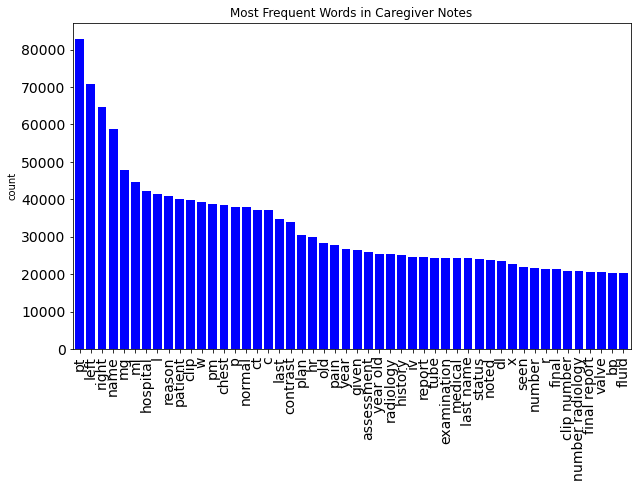

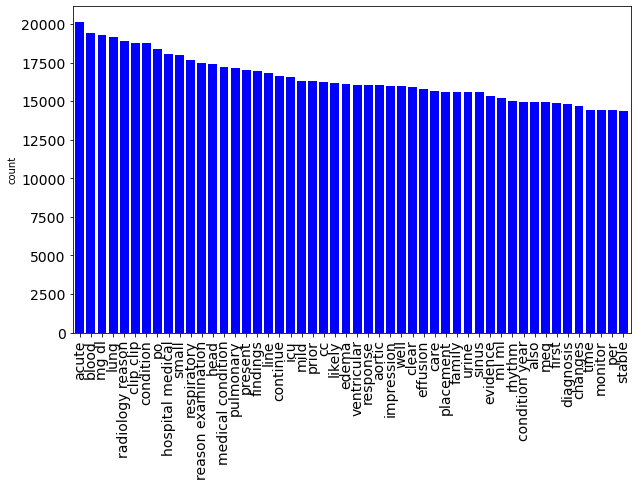

In [44]:
#Create a series from the sparse matrix
d = pd.Series(term_freq_df.total, 
              index = term_freq_df.index).sort_values(ascending=False)

#Visualize the 100 most frequent words in the text
ax = d[:50].plot(kind='bar', figsize=(10,6), width=.8, fontsize=14, rot=90,color = 'b')
ax.title.set_size(18)
plt.title('Most Frequent Words in Caregiver Notes')
plt.ylabel('count')
plt.show()
ax = d[50:100].plot(kind='bar', figsize=(10,6), width=.8, fontsize=14, rot=90,color = 'b')
ax.title.set_size(18)
plt.ylabel('count')
plt.show()

In [45]:
#with np.printoptions(threshold=np.inf):
 #   print(neg_doc_matrix)

In [46]:
stopwords_updated = list(stopwords) + ['pt', 'left', 'right', 'name','patient', 'p','c']


Add the list of stop words as an argument for CountVectorizer

In [48]:

from sklearn.feature_extraction.text import CountVectorizer
vect = CountVectorizer(max_features = 3000, 
                       ngram_range = (1,2),
                       tokenizer = text_tokenizer, 
                       stop_words = stopwords_updated)
# this will take a while
vect.fit(df_train_final.TEXT.values)


C:\Users\caras\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:484: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


CountVectorizer(max_features=3000, ngram_range=(1, 2),
                stop_words=["that'll", "wasn't", 'while', 'than', 'their',
                            "haven't", 'again', 'your', "aren't", 'for',
                            'about', 'been', 'other', 'herself', 'my', 'does',
                            "hasn't", "she's", 'further', 'after', 'where',
                            'whom', 'out', 'what', 'ourselves', 'through',
                            'because', 'were', 'its', 'yours', ...],
                tokenizer=<function text_tokenizer at 0x0000021D45962DC0>)

In [49]:
#Again visualize find the most frequent words.

import matplotlib.pyplot as plt

neg_doc_matrix = vect.transform(df_train_final[df_train_final.HOSPITAL_EXPIRE_FLAG == 0].TEXT)
pos_doc_matrix = vect.transform(df_train_final[df_train_final.HOSPITAL_EXPIRE_FLAG == 1].TEXT)
neg_tf = np.sum(neg_doc_matrix,axis=0)
pos_tf = np.sum(pos_doc_matrix,axis=0)
neg = np.squeeze(np.asarray(neg_tf))
pos = np.squeeze(np.asarray(pos_tf))

term_freq_df = pd.DataFrame([neg,pos],columns=vect.get_feature_names()).transpose()
term_freq_df.columns = ['negative', 'positive']
term_freq_df['total'] = term_freq_df['negative'] + term_freq_df['positive']
term_freq_df.sort_values(by='total', ascending=False).iloc[:20]


,negative,positive,total
mg,21978,25947,47925
ml,20856,23814,44670
hospital,18074,24135,42209
l,18766,22631,41397
reason,16486,24392,40878
clip,16279,23635,39914
w,17238,22152,39390
pm,16850,22023,38873
chest,16672,21728,38400
normal,19720,18235,37955


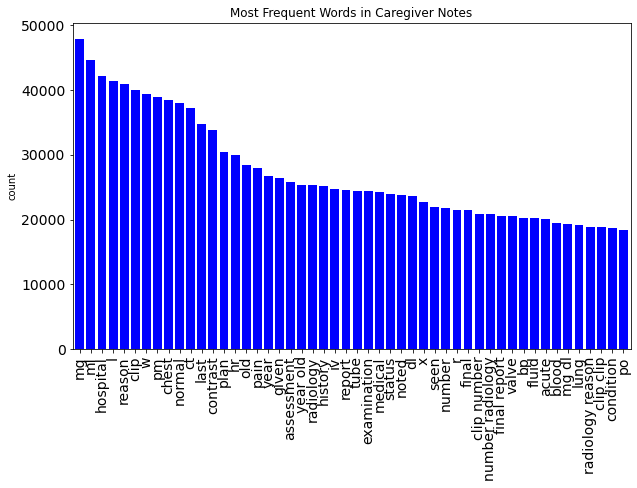

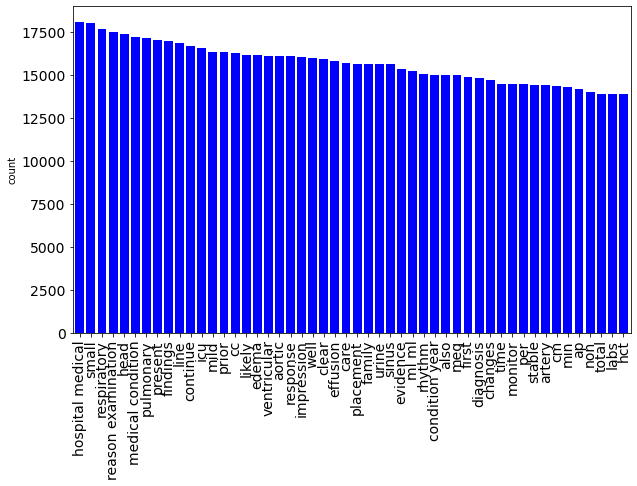

In [51]:
#Again Create a series from the sparse matrix
d = pd.Series(term_freq_df.total, 
              index = term_freq_df.index).sort_values(ascending=False)

#Visualize the 100 most frequent words in the text
ax = d[:50].plot(kind='bar', figsize=(10,6), width=.8, fontsize=14, rot=90,color = 'b')
ax.title.set_size(18)
plt.title('Most Frequent Words in Caregiver Notes')
plt.ylabel('count')
plt.show()
ax = d[50:100].plot(kind='bar', figsize=(10,6), width=.8, fontsize=14, rot=90,color = 'b')
ax.title.set_size(18)
plt.ylabel('count')
plt.show() 

Next, transform the tokens into vectors

In [52]:
X_train_vect = vect.transform(df_train_final.TEXT.values)
X_valid_vect = vect.transform(df_valid.TEXT.values)
X_test_vect = vect.transform(df_test.TEXT.values)

In [53]:
X_train_vect.shape

(6410, 3000)

In [77]:
type(X_train_vect)

scipy.sparse.csr.csr_matrix

Get labels (target/outcome variable)

In [54]:
y_train = df_train_final.HOSPITAL_EXPIRE_FLAG
y_valid = df_valid.HOSPITAL_EXPIRE_FLAG
y_test = df_test.HOSPITAL_EXPIRE_FLAG

In [98]:
# Convert sparse matrices and pandas series to csv for the next step.
from scipy.sparse.csr_matrix import todense

df = pd.DataFrame(data=todense(X_train_vect))
#df.to_csv('X_train_vect.csv', index=False)

ModuleNotFoundError: No module named 'scipy.sparse.csr_matrix'

Step 3: Build a simple predictive model

In [55]:
# logistic regression
from sklearn.linear_model import LogisticRegression
clf=LogisticRegression(random_state = 42, solver='lbfgs')
clf.fit(X_train_vect, y_train)

C:\Users\caras\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(random_state=42)

In [99]:
#import other models for evaluation
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import Pipeline

rf = RandomForestClassifier(random_state=42, n_estimators=100)
svm = SVC(random_state=42, gamma='auto', probability=True)
gnb = GaussianNB()


rf.fit(X_train_vect, y_train)

svm.fit(X_train_vect, y_train)

gnb.fit(X_train_vect.toarray(), y_train)



GaussianNB()

Calculate probability of death.

In [100]:
model = clf
y_train_preds = model.predict_proba(X_train_vect)[:,1]
y_valid_preds = model.predict_proba(X_valid_vect)[:,1]

In [101]:
#Print mortality predictions for the first 10 samples in the training set
print(y_train[:10].values)
print(y_train_preds[:10])


[0 1 0 1 0 1 0 0 1 1]
[0.20923793 0.72235179 0.38417088 0.6222399  0.66876978 0.67110744
 0.37935791 0.59346041 0.60890442 0.84525951]


In [102]:
model = gnb
y_train_preds_gnb = model.predict_proba(X_train_vect.toarray())[:,1]
y_valid_preds_gnb = model.predict_proba(X_valid_vect.toarray())[:,1]

In [103]:
model=rf
y_train_preds_rf = model.predict_proba(X_train_vect)[:,1]
y_valid_preds_rf = model.predict_proba(X_valid_vect.toarray())[:,1]

In [104]:
model = svm
y_train_preds_svm = model.predict_proba(X_train_vect)[:,1]
y_valid_preds_svm = model.predict_proba(X_valid_vect.toarray())[:,1]

In [105]:
#Print mortality predictions for the first 10 samples in the training set
print(y_train[:10].values)
print(y_train_preds[:10])


[0 1 0 1 0 1 0 0 1 1]
[0.20923793 0.72235179 0.38417088 0.6222399  0.66876978 0.67110744
 0.37935791 0.59346041 0.60890442 0.84525951]


Calculate performance metrics

In [106]:
#Create functions to calculate performanece metrics
def calc_accuracy(y_actual, y_pred, thresh):
    # this function calculates the accuracy with probability threshold at thresh
    return (sum((y_pred > thresh) & (y_actual == 1))+sum((y_pred < thresh) & (y_actual == 0))) /len(y_actual)

def calc_recall(y_actual, y_pred, thresh):
    # calculates the recall
    return sum((y_pred > thresh) & (y_actual == 1)) /sum(y_actual)

def calc_precision(y_actual, y_pred, thresh):
    # calculates the precision
    return sum((y_pred > thresh) & (y_actual == 1)) /sum(y_pred > thresh)

def calc_specificity(y_actual, y_pred, thresh):
    # calculates specificity
    return sum((y_pred < thresh) & (y_actual == 0)) /sum(y_actual ==0)

def calc_prevalence(y_actual):
    # calculates prevalence
    return sum((y_actual == 1)) /len(y_actual)


Logistic Regression Performance Metrics

AUC:
Train:0.866
Valid:0.817

Accuracy:
Train:0.774
Valid:0.759

Recall:
Train:0.745
Valid:0.698

Precision:
Train:0.790
Valid:0.212

Specificity
Train:0.802
Valid:0.765

Prevalence
Train:0.500
Valid:0.083


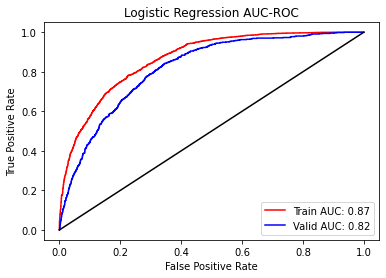

In [107]:
#LOGISTIC REGRESSION
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_train_preds)
fpr_valid, tpr_valid, thresholds_valid = roc_curve(y_valid, y_valid_preds)


thresh = 0.5

auc_train = roc_auc_score(y_train, y_train_preds)
auc_valid = roc_auc_score(y_valid, y_valid_preds)

print("\nLogistic Regression Performance Metrics\n")
print('AUC:')
print('Train:%.3f'%auc_train)
print('Valid:%.3f'%auc_valid)

print('\nAccuracy:')
print('Train:%.3f'%calc_accuracy(y_train, y_train_preds, thresh))
print('Valid:%.3f'%calc_accuracy(y_valid, y_valid_preds, thresh))

print('\nRecall:')
print('Train:%.3f'%calc_recall(y_train, y_train_preds, thresh))
print('Valid:%.3f'%calc_recall(y_valid, y_valid_preds, thresh))

print('\nPrecision:')
print('Train:%.3f'%calc_precision(y_train, y_train_preds, thresh))
print('Valid:%.3f'%calc_precision(y_valid, y_valid_preds, thresh))

print('\nSpecificity')
print('Train:%.3f'%calc_specificity(y_train, y_train_preds, thresh))
print('Valid:%.3f'%calc_specificity(y_valid, y_valid_preds, thresh))

print('\nPrevalence')
print('Train:%.3f'%calc_prevalence(y_train))
print('Valid:%.3f'%calc_prevalence(y_valid))


plt.plot(fpr_train, tpr_train,'r-', label = 'Train AUC: %.2f'%auc_train)
plt.plot(fpr_valid, tpr_valid,'b-',label = 'Valid AUC: %.2f'%auc_valid)
plt.plot([0,1],[0,1],'-k')
plt.title('Logistic Regression AUC-ROC')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()


Naive Bayes Performance Metrics

Train AUC:0.858
Valid AUC:0.603
Train accuracy:0.856
Valid accuracy:0.702
Train recall:0.714
Valid recall:0.478
Train precision:0.999
Valid precision:0.135
Train specificity:0.999
Valid specificity:0.722
Train prevalence:0.500
Valid prevalence:0.083


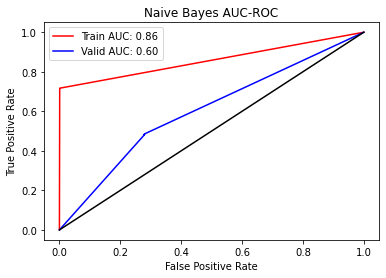

In [108]:
#GNB
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_train_preds_gnb)
fpr_valid, tpr_valid, thresholds_valid = roc_curve(y_valid, y_valid_preds_gnb)


thresh = 0.5

auc_train = roc_auc_score(y_train, y_train_preds_gnb)
auc_valid = roc_auc_score(y_valid, y_valid_preds_gnb)
print("\nNaive Bayes Performance Metrics\n")
print('Train AUC:%.3f'%auc_train)
print('Valid AUC:%.3f'%auc_valid)

print('Train accuracy:%.3f'%calc_accuracy(y_train, y_train_preds_gnb, thresh))
print('Valid accuracy:%.3f'%calc_accuracy(y_valid, y_valid_preds_gnb, thresh))


print('Train recall:%.3f'%calc_recall(y_train, y_train_preds_gnb, thresh))
print('Valid recall:%.3f'%calc_recall(y_valid, y_valid_preds_gnb, thresh))

print('Train precision:%.3f'%calc_precision(y_train, y_train_preds_gnb, thresh))
print('Valid precision:%.3f'%calc_precision(y_valid, y_valid_preds_gnb, thresh))

print('Train specificity:%.3f'%calc_specificity(y_train, y_train_preds_gnb, thresh))
print('Valid specificity:%.3f'%calc_specificity(y_valid, y_valid_preds_gnb, thresh))

print('Train prevalence:%.3f'%calc_prevalence(y_train))
print('Valid prevalence:%.3f'%calc_prevalence(y_valid))


plt.plot(fpr_train, tpr_train,'r-', label = 'Train AUC: %.2f'%auc_train)
plt.plot(fpr_valid, tpr_valid,'b-',label = 'Valid AUC: %.2f'%auc_valid)
plt.plot([0,1],[0,1],'-k')
plt.title('Naive Bayes AUC-ROC')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()


Random Forest Performance Metrics

Train AUC:1.000
Valid AUC:0.807
Train accuracy:1.000
Valid accuracy:0.650
Train recall:1.000
Valid recall:0.789
Train precision:1.000
Valid precision:0.173
Train specificity:1.000
Valid specificity:0.638
Train prevalence:0.500
Valid prevalence:0.083


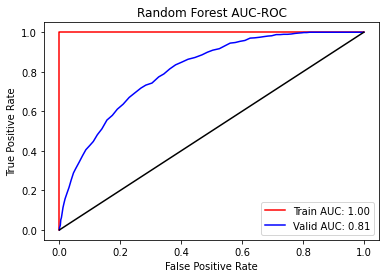

In [109]:
#RF
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_train_preds_rf)
fpr_valid, tpr_valid, thresholds_valid = roc_curve(y_valid, y_valid_preds_rf)


thresh = 0.5

auc_train = roc_auc_score(y_train, y_train_preds_rf)
auc_valid = roc_auc_score(y_valid, y_valid_preds_rf)
print("\nRandom Forest Performance Metrics\n")
print('Train AUC:%.3f'%auc_train)
print('Valid AUC:%.3f'%auc_valid)

print('Train accuracy:%.3f'%calc_accuracy(y_train, y_train_preds_rf, thresh))
print('Valid accuracy:%.3f'%calc_accuracy(y_valid, y_valid_preds_rf, thresh))


print('Train recall:%.3f'%calc_recall(y_train, y_train_preds_rf, thresh))
print('Valid recall:%.3f'%calc_recall(y_valid, y_valid_preds_rf, thresh))

print('Train precision:%.3f'%calc_precision(y_train, y_train_preds_rf, thresh))
print('Valid precision:%.3f'%calc_precision(y_valid, y_valid_preds_rf, thresh))

print('Train specificity:%.3f'%calc_specificity(y_train, y_train_preds_rf, thresh))
print('Valid specificity:%.3f'%calc_specificity(y_valid, y_valid_preds_rf, thresh))

print('Train prevalence:%.3f'%calc_prevalence(y_train))
print('Valid prevalence:%.3f'%calc_prevalence(y_valid))


plt.plot(fpr_train, tpr_train,'r-', label = 'Train AUC: %.2f'%auc_train)
plt.plot(fpr_valid, tpr_valid,'b-',label = 'Valid AUC: %.2f'%auc_valid)
plt.plot([0,1],[0,1],'-k')
plt.title('Random Forest AUC-ROC')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()


SVM Performance Metrics

Train AUC:0.869
Valid AUC:0.804
Train accuracy:0.775
Valid accuracy:0.730
Train recall:0.746
Valid recall:0.681
Train precision:0.799
Valid precision:0.193
Train specificity:0.803
Valid specificity:0.735
Train prevalence:0.500
Valid prevalence:0.083


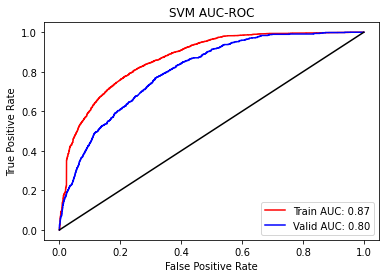

In [110]:
#svm
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_train_preds_svm)
fpr_valid, tpr_valid, thresholds_valid = roc_curve(y_valid, y_valid_preds_svm)


thresh = 0.5

auc_train = roc_auc_score(y_train, y_train_preds_svm)
auc_valid = roc_auc_score(y_valid, y_valid_preds_svm)
print("\nSVM Performance Metrics\n")
print('Train AUC:%.3f'%auc_train)
print('Valid AUC:%.3f'%auc_valid)

print('Train accuracy:%.3f'%calc_accuracy(y_train, y_train_preds_svm, thresh))
print('Valid accuracy:%.3f'%calc_accuracy(y_valid, y_valid_preds_svm, thresh))


print('Train recall:%.3f'%calc_recall(y_train, y_train_preds_svm, thresh))
print('Valid recall:%.3f'%calc_recall(y_valid, y_valid_preds_svm, thresh))

print('Train precision:%.3f'%calc_precision(y_train, y_train_preds_svm, thresh))
print('Valid precision:%.3f'%calc_precision(y_valid, y_valid_preds_svm, thresh))

print('Train specificity:%.3f'%calc_specificity(y_train, y_train_preds_svm, thresh))
print('Valid specificity:%.3f'%calc_specificity(y_valid, y_valid_preds_svm, thresh))

print('Train prevalence:%.3f'%calc_prevalence(y_train))
print('Valid prevalence:%.3f'%calc_prevalence(y_valid))


plt.plot(fpr_train, tpr_train,'r-', label = 'Train AUC: %.2f'%auc_train)
plt.plot(fpr_valid, tpr_valid,'b-',label = 'Valid AUC: %.2f'%auc_valid)
plt.plot([0,1],[0,1],'-k')
plt.title('SVM AUC-ROC')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

### Since the performance metrics results and AUC-ROC fared better with Logistic Regression, that will be the model of choice for the remainder of this project.
#### The remainder of this analysis will focus on feature engineering and hyperparameter optimization in order to create a stronger algorithm to predict mortality. 

### Feature Importance

In [111]:
#First find the features that the classifier is using to make decisions. The features with the highest coefficients predict death and the lowest coefficents predict no death.

def get_most_important_features(vectorizer, model, n=5):
    index_to_word = {v:k for k,v in vectorizer.vocabulary_.items()}
    
    # loop for each class
    classes ={}
    for class_index in range(model.coef_.shape[0]):
        word_importances = [(el, index_to_word[i]) for i,el in enumerate(model.coef_[class_index])]
        sorted_coeff = sorted(word_importances, key = lambda x : x[0], reverse=True)
        tops = sorted(sorted_coeff[:n], key = lambda x : x[0])
        bottom = sorted_coeff[-n:]
        classes[class_index] = {
            'tops':tops,
            'bottom':bottom
        }
    return classes

importance = get_most_important_features(vect, clf, 50)

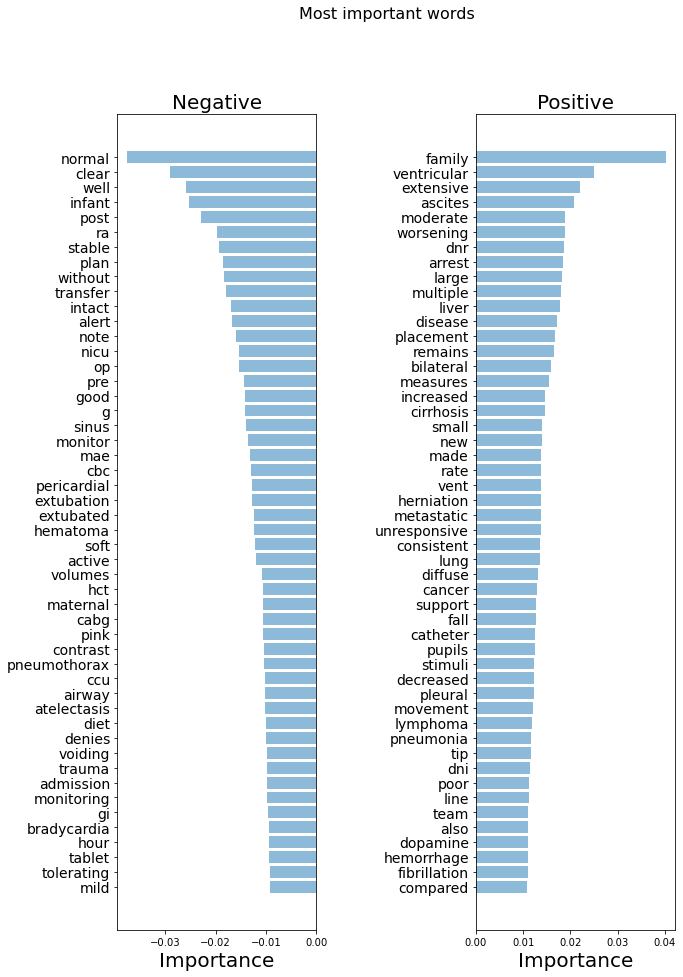

In [112]:
#Next, plot the most important features

def plot_important_words(top_scores, top_words, bottom_scores, bottom_words, name):
    y_pos = np.arange(len(top_words))
    top_pairs = [(a,b) for a,b in zip(top_words, top_scores)]
    top_pairs = sorted(top_pairs, key=lambda x: x[1])
    
    bottom_pairs = [(a,b) for a,b in zip(bottom_words, bottom_scores)]
    bottom_pairs = sorted(bottom_pairs, key=lambda x: x[1], reverse=True)
    
    top_words = [a[0] for a in top_pairs]
    top_scores = [a[1] for a in top_pairs]
    
    bottom_words = [a[0] for a in bottom_pairs]
    bottom_scores = [a[1] for a in bottom_pairs]
    
    fig = plt.figure(figsize=(10, 15))  

    plt.subplot(121)
    plt.barh(y_pos,bottom_scores, align='center', alpha=0.5)
    plt.title('Negative', fontsize=20)
    plt.yticks(y_pos, bottom_words, fontsize=14)
    plt.suptitle('Key words', fontsize=16)
    plt.xlabel('Importance', fontsize=20)
    
    plt.subplot(122)
    plt.barh(y_pos,top_scores, align='center', alpha=0.5)
    plt.title('Positive', fontsize=20)
    plt.yticks(y_pos, top_words, fontsize=14)
    plt.suptitle(name, fontsize=16)
    plt.xlabel('Importance', fontsize=20)
    
    plt.subplots_adjust(wspace=0.8)
    plt.show()

    
  
top_scores = [a[0] for a in importance[0]['tops']]
top_words = [a[1] for a in importance[0]['tops']]
bottom_scores = [a[0] for a in importance[0]['bottom']]
bottom_words = [a[1] for a in importance[0]['bottom']]

plot_important_words(top_scores, top_words, bottom_scores, bottom_words, "Most important words")


### Hyperparameter tuning

In [113]:
#Begin by plotting a learning curve. This will help to assure that we have enough samples to make good predictions.  

import numpy as np
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit


def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - An object to be used as a cross-validation generator.
          - An iterable yielding train/test splits.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
        """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Number of Training examples")
    plt.ylabel("AUC")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring = 'roc_auc')
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="b")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="b",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

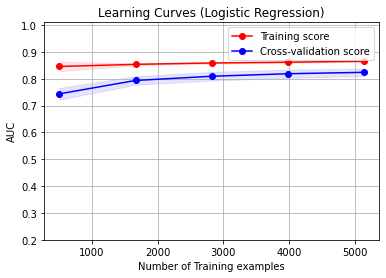

In [114]:

title = "Learning Curves (Logistic Regression)"
# Cross validation with 5 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
estimator = LogisticRegression( C = 0.0001, penalty = 'l2')#
plot_learning_curve(estimator, title, X_train_vect, y_train, ylim=(0.2, 1.01), cv=cv, n_jobs=4)

plt.show()


The AUC of the training set is high, and the CV score is also high, and begins to approach the Training score curve as number of samples increases. This means that the  model is learning well with the number of samples provided; more data would not necessarily make the model better. Some overfitting is indicated since there is a gap between the training score and cross validation score.

In [115]:
clf.coef_

array([[-2.82664164e-05,  4.08770422e-04,  6.01251674e-03, ...,
        -3.30559712e-06, -5.38597149e-05,  8.29264447e-05]])

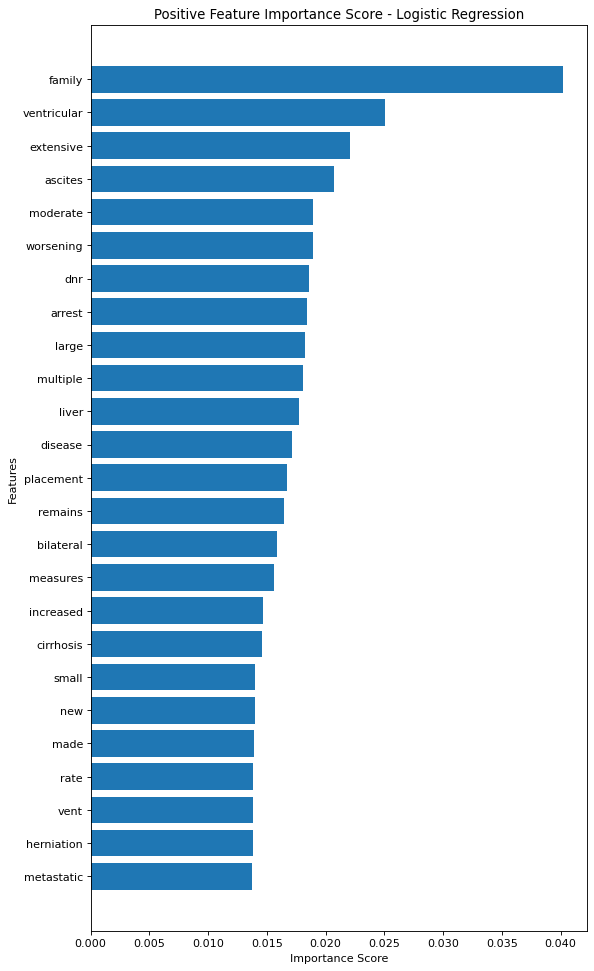

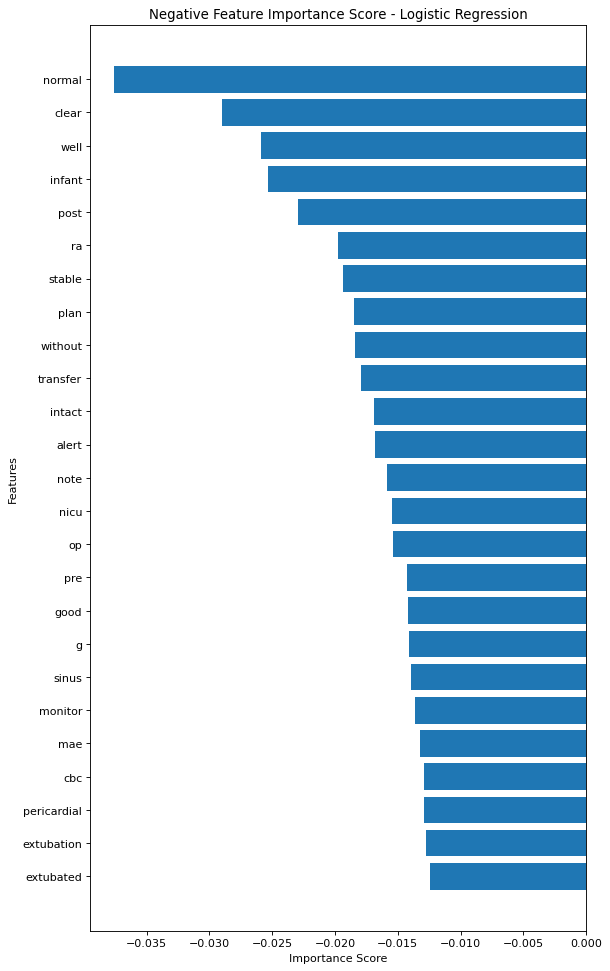

In [116]:
#Look at the most important words for the model.

feature_importances = pd.DataFrame(clf.coef_[0],
                                   index = vect.get_feature_names(),
                                    columns=['importance']).sort_values('importance',
                                                                        ascending=False)

num=25
ylocs = np.arange(num)
# get the feature importance for top num and sort in reverse order
values_to_plot = feature_importances.iloc[:num].values.ravel()[::-1]
feature_labels = list(feature_importances.iloc[:num].index)[::-1]

plt.figure(num=None, figsize=(8, 15), dpi=80, facecolor='w', edgecolor='k');
plt.barh(ylocs, values_to_plot, align = 'center')
plt.ylabel('Features')
plt.xlabel('Importance Score')
plt.title('Positive Feature Importance Score - Logistic Regression')
plt.yticks(ylocs, feature_labels)
plt.show()

values_to_plot = feature_importances.iloc[-num:].values.ravel()
feature_labels = list(feature_importances.iloc[-num:].index)

plt.figure(num=None, figsize=(8, 15), dpi=80, facecolor='w', edgecolor='k');
plt.barh(ylocs, values_to_plot, align = 'center')
plt.ylabel('Features')
plt.xlabel('Importance Score')
plt.title('Negative Feature Importance Score - Logistic Regression')
plt.yticks(ylocs, feature_labels)
plt.show()





 C: 1e-05
Train AUC:0.788
Valid AUC:0.759

 C: 0.0001
Train AUC:0.866
Valid AUC:0.817

 C: 0.001


C:\Users\caras\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Train AUC:0.930
Valid AUC:0.835

 C: 0.005


C:\Users\caras\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Train AUC:0.969
Valid AUC:0.828

 C: 0.01


C:\Users\caras\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Train AUC:0.981
Valid AUC:0.822

 C: 0.05


C:\Users\caras\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Train AUC:0.994
Valid AUC:0.809

 C: 0.1
Train AUC:0.995
Valid AUC:0.802


C:\Users\caras\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


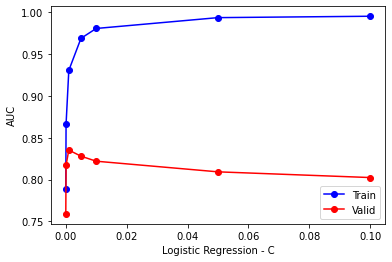

In [117]:
# Find best value of C


from sklearn.linear_model import LogisticRegression

Cs = [0.00001, 0.0001, 0.001, 0.005, 0.01, 0.05, 0.1]
train_aucs = np.zeros(len(Cs))
valid_aucs = np.zeros(len(Cs))

for ii in range(len(Cs)):
    C = Cs[ii]
    print('\n C:', C)
    
    # logistic regression
    
    clf=LogisticRegression(C = C, penalty = 'l2', random_state = 42)
    clf.fit(X_train_vect, y_train)

    model = clf
    y_train_preds = model.predict_proba(X_train_vect)[:,1]
    y_valid_preds = model.predict_proba(X_valid_vect)[:,1]

    auc_train = roc_auc_score(y_train, y_train_preds)
    auc_valid = roc_auc_score(y_valid, y_valid_preds)
    print('Train AUC:%.3f'%auc_train)
    print('Valid AUC:%.3f'%auc_valid)
    train_aucs[ii] = auc_train
    valid_aucs[ii] = auc_valid


plt.plot(Cs, train_aucs,'bo-', label ='Train')
plt.plot(Cs, valid_aucs, 'ro-', label='Valid')
plt.legend()
plt.xlabel('Logistic Regression - C')
plt.ylabel('AUC')
plt.show()







As C gets larger, overfitting quickly occurs as shown by the gap between training and validation. The best values for C are 0.0001 and 0.001, based on the individual ROC-AUC and difference between  training and validation ROC-AUC scores at those values of C.


number of features: 100


C:\Users\caras\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:484: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


Train AUC: 0.771
Valid AUC:0.758

number of features: 300


C:\Users\caras\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:484: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


Train AUC: 0.810
Valid AUC:0.786

number of features: 1000


C:\Users\caras\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:484: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


Train AUC: 0.846
Valid AUC:0.808

number of features: 3000


C:\Users\caras\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:484: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


Train AUC: 0.861
Valid AUC:0.816

number of features: 10000


C:\Users\caras\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:484: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


Train AUC: 0.866
Valid AUC:0.817

number of features: 30000


C:\Users\caras\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:484: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


Train AUC: 0.866
Valid AUC:0.817


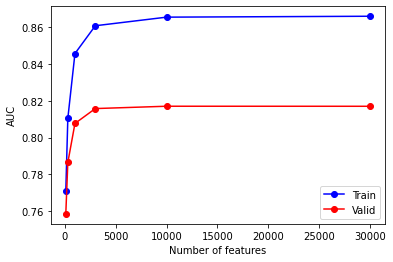

In [118]:
#Countvectorizer is currently using 3000 maximum tokens. Next examine the effect of Max_features on performance.





num_features = [100,300,1000,3000,10000,30000]
train_aucs = np.zeros(len(num_features))
valid_aucs = np.zeros(len(num_features))

for ii in range(len(num_features)):
    num = num_features[ii]
    print('\nnumber of features:', num)
    vect = CountVectorizer(lowercase = True, max_features = num, 
                           tokenizer = text_tokenizer,stop_words =stopwords_updated)

    # This could take a while
    vect.fit(df_train_final.TEXT.values)

    X_train_vect = vect.transform(df_train_final.TEXT.values)
    X_valid_vect = vect.transform(df_valid.TEXT.values)
    y_train = df_train_final.HOSPITAL_EXPIRE_FLAG
    y_valid = df_valid.HOSPITAL_EXPIRE_FLAG
    
    clf=LogisticRegression(C = 0.0001, penalty = 'l2', random_state = 42)
    clf.fit(X_train_vect, y_train)

    model = clf
    y_train_preds = model.predict_proba(X_train_vect)[:,1]
    y_valid_preds = model.predict_proba(X_valid_vect)[:,1]

    auc_train = roc_auc_score(y_train, y_train_preds)
    auc_valid = roc_auc_score(y_valid, y_valid_preds)
    print('Train AUC: %.3f'%auc_train)
    print('Valid AUC:%.3f'%auc_valid)
    train_aucs[ii] = auc_train
    valid_aucs[ii] = auc_valid

plt.plot(num_features, train_aucs,'bo-', label ='Train')
plt.plot(num_features, valid_aucs, 'ro-', label='Valid')
plt.legend()
plt.xlabel('Number of features')
plt.ylabel('AUC')
plt.show()

As max_features gets larger, some overfitting quickly occurs. AUC begins leveling out for both Training and Validation at about 3000-4000 words. Therefore, the current setting for max_features is appropriate.

In [119]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold

clf_param_grid = {'penalty': ['l1','l2'],
                  'C': [0.001, 0.01, 0.1, 1, 2],
                  'class_weight': [{1:0.5, 0:0.5}, {1:0.6, 0:0.4}, {1:0.7, 0:0.3}, {1:0.8, 0:0.2}, {1:0.9, 0:0.1}]
                   }
clf = GridSearchCV(
    estimator=clf,
    param_grid=clf_param_grid,               
    n_jobs=-1,
    scoring='f1',
    cv=StratifiedKFold(n_splits=5,shuffle=True))
logistic_best_model = clf.fit(X_train_vect, y_train)

print('Best Logistic Score (F1): ', logistic_best_model.best_score_)
print('Best Logistic Parameters: ', logistic_best_model.best_params_)

Best Logistic Score (F1):  0.7803662704105726
Best Logistic Parameters:  {'C': 0.001, 'class_weight': {1: 0.6, 0: 0.4}, 'penalty': 'l2'}


C:\Users\caras\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [120]:
from sklearn.metrics import classification_report, confusion_matrix 

#Re-running predictions and see classification report on this grid object
clf_best_model = logistic_best_model.predict(X_test_vect) 

print('Logistic Classification Report\n\n', classification_report(y_test, clf_best_model))
print('Confusion Matrix \n\n', confusion_matrix(y_test, clf_best_model))

ValueError: X has 3000 features per sample; expecting 30000

In [ ]:
from sklearn.linear_model import LogisticRegression

clf_best=LogisticRegression(C = 0.001, penalty = 'l2',class_weight={1: 0.6, 0: 0.4}, random_state = 42, n_jobs=-1)
clf_best.fit(X_train_vect, y_train)

model = clf_best


In [ ]:
y_train_preds = model.predict_proba(X_train_vect)[:,1]
y_valid_preds = model.predict_proba(X_valid_vect)[:,1]
y_test_preds = model.predict_proba(X_test_vect)[:,1]


In [ ]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_train_preds)
fpr_valid, tpr_valid, thresholds_valid = roc_curve(y_valid, y_valid_preds)
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_test_preds)


thresh = 0.5

auc_train = roc_auc_score(y_train, y_train_preds)
auc_valid = roc_auc_score(y_valid, y_valid_preds)
auc_test = roc_auc_score(y_test, y_test_preds)

print("\nBest Model Performance Metrics\n")
print('\nAUC:')
print('Train:%.3f'%auc_train)
print('Valid:%.3f'%auc_valid)
print('Test:%.3f'%auc_test)

print('\nAccuracy')
print('Train:%.3f'%calc_accuracy(y_train, y_train_preds, thresh))
print('Valid:%.3f'%calc_accuracy(y_valid, y_valid_preds, thresh))
print('Test:%.3f'%calc_accuracy(y_test, y_test_preds, thresh))

print('\nRecall')
print('Train:%.3f'%calc_recall(y_train, y_train_preds, thresh))
print('Valid:%.3f'%calc_recall(y_valid, y_valid_preds, thresh))
print('Test:%.3f'%calc_recall(y_test, y_test_preds, thresh))

print('\nPrecision')
print('Train:%.3f'%calc_precision(y_train, y_train_preds, thresh))
print('Valid:%.3f'%calc_precision(y_valid, y_valid_preds, thresh))
print('Test:%.3f'%calc_precision(y_test, y_test_preds, thresh))

print('\nSpecificity')
print('Train:%.3f'%calc_specificity(y_train, y_train_preds, thresh))
print('Valid:%.3f'%calc_specificity(y_valid, y_valid_preds, thresh))
print('Test:%.3f'%calc_specificity(y_test, y_test_preds, thresh))

print('\nPrevalence')
print('Train:%.3f'%calc_prevalence(y_train))
print('Valid:%.3f'%calc_prevalence(y_valid))
print('Test:%.3f'%calc_prevalence(y_test))


plt.plot(fpr_train, tpr_train,'r-', label = 'Train AUC: %.2f'%auc_train)
plt.plot(fpr_valid, tpr_valid,'b-',label = 'Valid AUC: %.2f'%auc_valid)
plt.plot(fpr_test, tpr_test,'g-',label = 'Test AUC: %.2f'%auc_test)

plt.plot([0,1],[0,1],'-k')
plt.title('Best Model AUC-ROC')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix 

#Re-running predictions and see classification report on this grid object
clf_best_model = model.predict(X_test_vect) 

print('Logistic Classification Report\n\n', classification_report(y_test, clf_best_model, labels=[1,0]))
print('Confusion Matrix \n\n', confusion_matrix(y_test, clf_best_model, labels=[1,0]))

In [ ]:
import pickle
# save the model for later use
filename = 'model.sav'
pickle.dump(model, open(filename, 'wb'))
 




In [ ]:
# some time later...
 
# load the model from disk
loaded_model = pickle.load(open('model.sav', 'rb'))
result = model.score(X_test_vect, y_test)
print(result)